In [14]:
!pip install -U sentence-transformers


Requirement already up-to-date: sentence-transformers in /opt/homebrew/Caskroom/miniconda/base/envs/Lab_Vision/lib/python3.8/site-packages (2.2.2)


The notebook focused on text clustering using various embedding techniques. The dataset we are using is the 20newsgroups dataset with 3 categories. The goal is to compare several embedding approaches such as sentence transformers, GloVe, TF-IDF, and BERT-CLS, and cluster the resulting embeddings. This comparison can help to determine which approach provides the best clustering performance for the given dataset.

To achieve this, we have taken several steps. First, we have preprocessed the text data and converted it into numerical representations using the different embedding approaches. Next, we have applied clustering algorithms to the resulting embeddings to group the documents into clusters. Finally, you have compared the performance of the different embedding approaches by evaluating the quality of the resulting clusters using relevant metrics such as silhouette score or purity.

By comparing the different embedding approaches, we can gain insights into which technique is most effective for clustering text data in general, and for the 20newsgroups dataset in particular. This information can be valuable for future projects involving text clustering, as it can inform the selection of the most appropriate embedding approach for a given dataset and task.

In [19]:
from sentence_transformers import SentenceTransformer
import torch
from transformers import BertTokenizer, BertModel
import time

from torchtext.vocab import GloVe

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
from sklearn.decomposition import PCA

from gensim.models import KeyedVectors

import pandas as pd
import numpy as np


import re
import string
import nltk
from nltk.corpus import stopwords

# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielafrimi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
categories = [
 'comp.os.ms-windows.misc',
 'rec.sport.hockey',
 'soc.religion.christian',
]

dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))
data = {'text': dataset.data, 'target': dataset.target}
df = pd.DataFrame(data)

In [28]:
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text

In [29]:
df['text_cleaned'] = df['text'].apply(lambda text: preprocess_text(text))
df = df[df['text_cleaned'] != '']

In [99]:
df['len_words'] =  df['text_cleaned'].apply(lambda sentence: len(sentence.split()))

<ipython-input-99-a40bb7dbb324>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_words'] =  df['text_cleaned'].apply(lambda sentence: len(sentence.split()))


In [100]:
df['len_words'].describe()

count     1741.000000
mean       210.678346
std       1186.709529
min          1.000000
25%         24.000000
50%         52.000000
75%        103.000000
max      14724.000000
Name: len_words, dtype: float64

### TF-IDF Vectorization

This is a simple but effective method for generating vector representations of sentences. It stands for "term frequency-inverse document frequency" and it calculates the importance of words in a sentence by taking into account how often they appear in the sentence and how rare they are in the entire corpus of sentences. 



In [101]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X = vectorizer.fit_transform(df['text_cleaned']).toarray()

Cluster 0 refers to sport, cluster 2 to software / tech, cluster 3 to religion

In [102]:
def get_top_keywords(n_terms):
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

### Sentence Transformer
Sentence Transformers are deep learning models that can encode natural language sentences into high-dimensional vector representations. They are trained using a pre-training and fine-tuning approach and have achieved state-of-the-art performance on several natural language processing tasks. These models are widely used for various applications such as chatbots, search engines, and recommendation systems.

In [103]:
st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

Elapsed time: 86.46 seconds


<ipython-input-103-b9298d2af8c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encode_transforemers'] = df['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())


In [104]:
X_transformers = np.vstack(df['encode_transforemers'])

### Glove

GloVe is a word embedding technique that represents words as dense vectors in a high-dimensional space. It captures both local and global context, making it useful for various tasks. To cluster sentences using GloVe, one approach is to concatenate the word vectors in a sentence, form a matrix, and then apply a clustering algorithm such as k-means. The resulting clusters can reveal common themes or patterns in the data.

In [34]:
embeddings = GloVe(name='6B', dim=100)

.vector_cache/glove.6B.zip: 862MB [02:48, 5.11MB/s]                                
100%|█████████▉| 399999/400000 [00:14<00:00, 26698.42it/s]


In [117]:
# Set the maximum sentence length and embedding dimension
max_length = 100 
embedding_dim = 100

# define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
            
    return embedding_sentence.flatten()

In [106]:
df['encode_glove'] = df['text_cleaned'].apply(lambda sentence: sentence_embedding(sentence))

<ipython-input-106-000a85869f3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encode_glove'] = df['text_cleaned'].apply(lambda sentence: sentence_embedding(sentence))


In [107]:
X_glove = np.vstack(df['encode_glove'])

### BERT - [CLS] token for sentnce context

BERT, is a pre-trained deep learning model that can be fine-tuned for various natural language processing tasks. One of the main innovations of BERT is its ability to represent both the left and right context of a word, allowing it to better capture the meaning of a sentence.

In BERT, the [CLS] token, which stands for "classification", is a special token that is inserted at the beginning of every input sequence. During pre-training, BERT is trained to predict the correct class label for the entire sequence based on the [CLS] token representation, which is meant to capture the overall meaning of the sequence.

In [108]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [109]:
def get_cls_sentence(sentence):
    # Tokenize input sentence and convert to tensor
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

    # Pass input through BERT model and extract embeddings for [CLS] token
    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    
    return cls_embedding.flatten()

In [110]:
st = time.time()

df['cls_bert'] = df['text_cleaned'].apply(lambda sentence: get_cls_sentence(sentence))

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Elapsed time: 898.54 seconds


<ipython-input-110-d7dc56572319>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cls_bert'] = df['text_cleaned'].apply(lambda sentence: get_cls_sentence(sentence))


In [111]:
X_cls_bert = np.vstack(df['cls_bert'])

In [112]:
df[df['target'] == 2]['text_cleaned'].value_counts()

points mary taken heaven end life earth one piece evidence mary assumption heaven fact christian church ever claimed sight buried christian churches claimed located final resting places peter mark saints one ever claimed possess body mary greatest saints everyone knew taken heaven although definitive scriptural proof assumption mary passages seem suggestive like passage revelation describes woman giving birth son later crowned heavens course woman passage interpretations also taken symbol church assumption mary makes sense relationship christ jesus perfect god perfect man fulfilled requirements law perfectly law god gave us honor mother father christ act taking mother heaven part fulfillment law also took flesh seems appropriate decide allow flesh rot grave one last point ex catholic attempted explain catholic doctrine assumption asserting connected belief mary die correct summary catholics believe dogma assumption carefully phrased avoid saying whether mary die fact consensus among ca

### Clustering
#### 1. K-Means

<ipython-input-113-32ba735cf155>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clusters_result_name] = clusters


Adjusted Rand Index (ARI): 0.674
Normalized Mutual Information (NMI): 0.677
Fowlkes-Mallows Index (FMI): 0.786


<ipython-input-58-293c0b18ca87>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x0_{method}'] = x0
<ipython-input-58-293c0b18ca87>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x1_{method}'] = x1


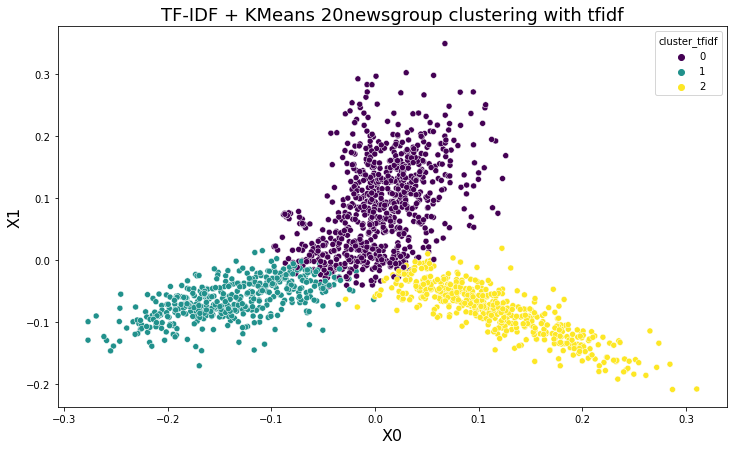

<ipython-input-113-32ba735cf155>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clusters_result_name] = clusters
<ipython-input-58-293c0b18ca87>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x0_{method}'] = x0
<ipython-input-58-293c0b18ca87>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Adjusted Rand Index (ARI): 0.877
Normalized Mutual Information (NMI): 0.822
Fowlkes-Mallows Index (FMI): 0.918


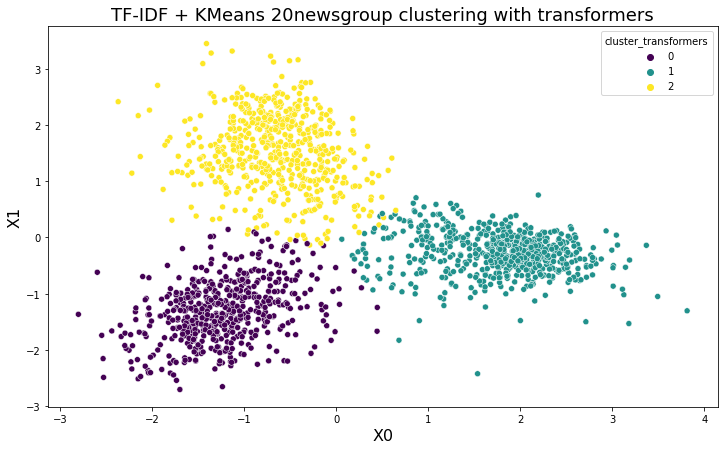

<ipython-input-113-32ba735cf155>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clusters_result_name] = clusters


Adjusted Rand Index (ARI): 0.068
Normalized Mutual Information (NMI): 0.062
Fowlkes-Mallows Index (FMI): 0.456


<ipython-input-58-293c0b18ca87>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x0_{method}'] = x0
<ipython-input-58-293c0b18ca87>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x1_{method}'] = x1


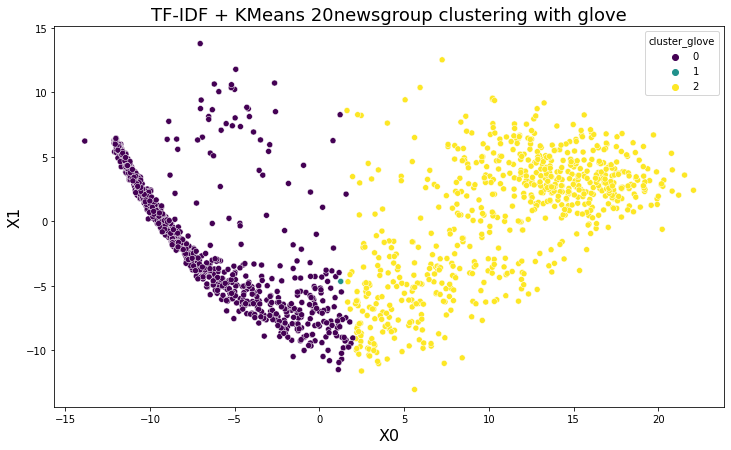

<ipython-input-113-32ba735cf155>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[clusters_result_name] = clusters


Adjusted Rand Index (ARI): 0.373
Normalized Mutual Information (NMI): 0.398
Fowlkes-Mallows Index (FMI): 0.586


<ipython-input-58-293c0b18ca87>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x0_{method}'] = x0
<ipython-input-58-293c0b18ca87>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'x1_{method}'] = x1


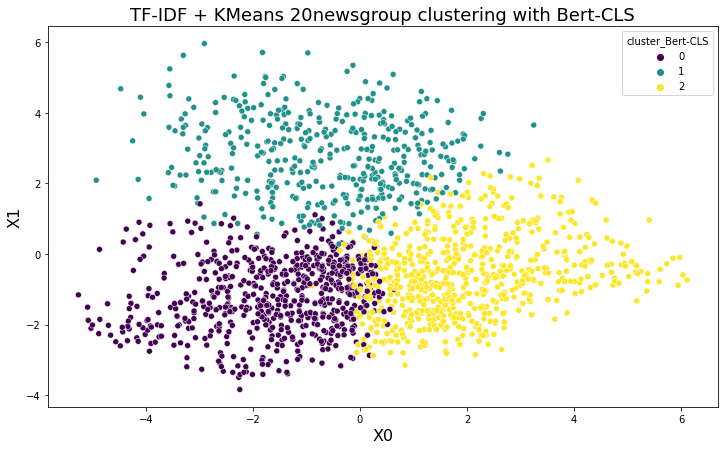

In [113]:
for embedding_and_method in [(X, 'tfidf'), (X_transformers, 'transformers'), (X_glove, 'glove'), ((X_cls_bert, 'Bert-CLS')) ]:
    embedding, method = embedding_and_method[0], embedding_and_method[1]
    
    # initialize kmeans with 3 centroids
    kmeans = KMeans(n_clusters=3, random_state=42)

    # fit the model
    kmeans.fit(embedding)

    # store cluster labels in a variable
    clusters = kmeans.labels_

    # Assign clusters to our dataframe
    clusters_result_name = f'cluster_{method}'
    df[clusters_result_name] = clusters
    
    eval_cluster(embedding)
    
    dimension_reduction(embedding, method)
    
    plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters_result_name, method=method)

To evaluate the performance of a clustering algorithm like k-means, we use various metrics that compare the predicted clusters to the ground truth labels. Here are a few common metrics:

Adjusted Rand Index (ARI): measures the similarity between the predicted clusters and the ground truth labels, taking into account chance agreement. ARI ranges from -1 to 1, where 1 indicates perfect agreement and 0 indicates random clustering.

Normalized Mutual Information (NMI): measures the mutual information between the predicted clusters and the ground truth labels, normalized by the entropy of the clusters and labels. NMI ranges from 0 to 1, where 1 indicates perfect agreement.

Fowlkes-Mallows Index (FMI): measures the geometric mean of the precision and recall of the predicted clusters with respect to the ground truth labels. FMI ranges from 0 to 1, where 1 indicates perfect agreement.

In [114]:
def eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)
    
    # Evaluate the performance using ARI, NMI, and FMI
    ari = adjusted_rand_score(df["target"], y_pred)
    nmi = normalized_mutual_info_score(df["target"], y_pred)
    fmi = fowlkes_mallows_score(df["target"], y_pred)

    # Print Metrics scores
    print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

### PCA & Vizualization

In [115]:
def dimension_reduction(embedding, method):

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    
    df[f'x0_{method}'] = x0 
    df[f'x1_{method}'] = x1 
    

In [116]:
def plot_pca(x0_name, x1_name, cluster_name, method):

    plt.figure(figsize=(12, 7))

    plt.title(f"TF-IDF + KMeans 20newsgroup clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=df, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()